# Auto-Regressive Models of Time Series
This lab captures weekly gross numbers [for a movie from boxofficemojo](http://www.boxofficemojo.com/movies/?page=weekly&id=furyroad.htm) and builds an AR model using linear regression.

In [92]:
# connect to page and find table with BeautifulSoup

from __future__ import print_function
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

url = 'http://www.boxofficemojo.com/movies/?page=weekly&id=furyroad.htm'

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, 'lxml')

weekly_gross_table = soup.find('table', {"class":"chart-wide"})

In [93]:
# write a function that iterates over each row and gets the gross for each weekend in theaters

def extract_gross_points_from_table(gross_table, gross_column=2):
    points = []
    rows = gross_table.find_all('tr')
    for row_no, row in enumerate(rows):
        columns = row.find_all('td')
        # skip first row (headers) or an empty row
        if row_no == 0 or len(columns)<=1:
            continue
        # take column 2 (weekly gross)        
        gross = columns[gross_column].text
        points.append(gross)
    return points

In [94]:
# print output

weekly_timeseries = extract_gross_points_from_table(weekly_gross_table)
for weekend, gross in enumerate(weekly_timeseries):
    print(weekend, gross)

0 $63,440,279
1 $38,849,255
2 $20,544,731
3 $11,643,562
4 $6,309,002
5 $4,555,993
6 $2,648,047
7 $1,645,168
8 $966,275
9 $601,794
10 $663,222
11 $471,641
12 $266,007
13 $190,614
14 $129,637
15 $119,106
16 $94,384
17 $473,315
18 $24,322


Gross is in text form with '$' sign and commas; let's clean it up with a quick helper function. We'll change our extraction function to use that.

In [95]:
# updated helper functions

def gross_text_to_int(gross_text):
    clean_text = gross_text.replace('$','').replace(',','')
    gross_as_int = int(clean_text)
    return gross_as_int
    
def extract_gross_points_from_table(gross_table, gross_column=2):
    points = []
    rows = gross_table.find_all('tr')
    for row_no, row in enumerate(rows):
        columns = row.find_all('td')
        # skip first row (headers) or an empty row
        if row_no == 0 or len(columns)<=1:
            continue
        # take column 2 (weekly gross)
        # We are using our helper function here
        # to make sure we have a number for gross
        gross = gross_text_to_int(columns[gross_column].text)
        # -----------
        points.append(gross)
    return points

In [96]:
# print output

weekly_timeseries = extract_gross_points_from_table(weekly_gross_table)
for weekend, gross in enumerate(weekly_timeseries):
    print(weekend, gross)

0 63440279
1 38849255
2 20544731
3 11643562
4 6309002
5 4555993
6 2648047
7 1645168
8 966275
9 601794
10 663222
11 471641
12 266007
13 190614
14 129637
15 119106
16 94384
17 473315
18 24322


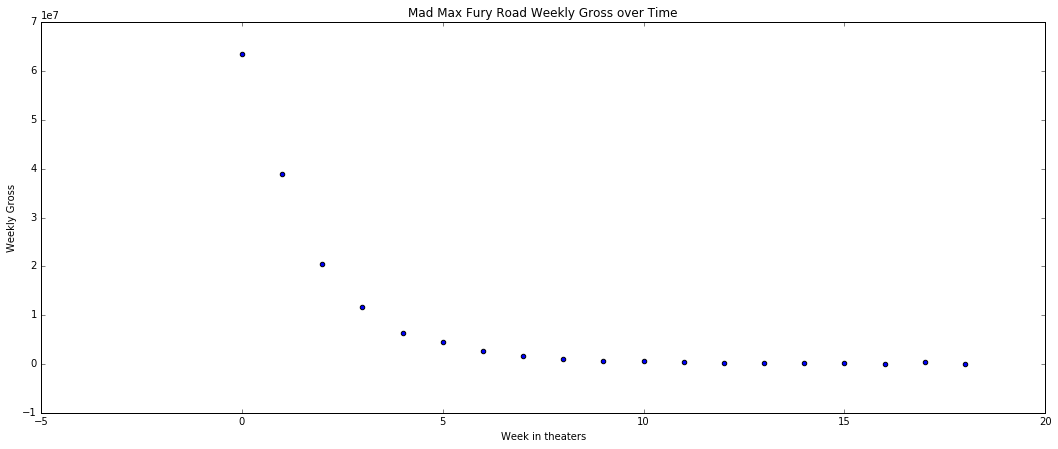

In [97]:
# plot weekly grosses

x = range(len(weekly_timeseries))
y = weekly_timeseries
plt.scatter(x,y)
plt.title("Mad Max Fury Road Weekly Gross over Time")
plt.xlabel("Week in theaters")
plt.ylabel("Weekly Gross")

As we can see, the gross drops pretty quickly. With this scale, it is hard to see the differences in the later weeks. One solution is to use log scale: instead of plotting gross numbers, we plot the _order of magnitude_ of weekly gross.

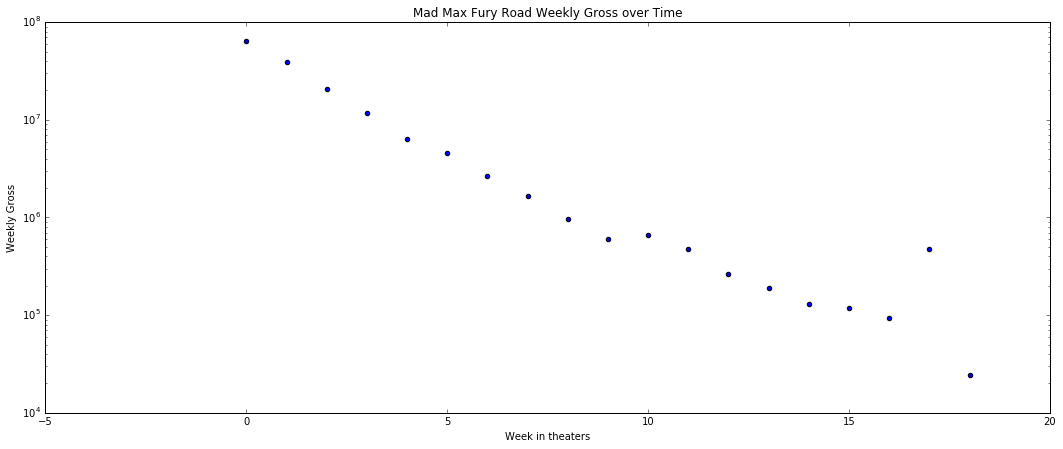

In [98]:
# plot with log scale

x = range(len(weekly_timeseries))
y = weekly_timeseries
plt.scatter(x,y)
plt.title("Mad Max Fury Road Weekly Gross over Time")
plt.xlabel("Week in theaters")
plt.ylabel("Weekly Gross")
plt.yscale("log")

AR models, meaning regression models that use the past as input features, are no different from regression with time-unrelated features. What we are doing is just using previous y-values as input for a given point. We can manually construct such features directly.

In [99]:
# load data into DataFrame
import pandas as pd

timeseries_df = pd.DataFrame(weekly_timeseries, columns=["weekly_gross"])
timeseries_df

,weekly_gross
0,63440279
1,38849255
2,20544731
3,11643562
4,6309002
5,4555993
6,2648047
7,1645168
8,966275
9,601794


We have only our target now: what we want to predict. As input for a given week, we want to know what the previous week's gross was. let's build that.

In [100]:
# create previous week feature

previous_weeks_grosses = [None] * len(weekly_timeseries)
previous_weeks_grosses

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [101]:
for week in range(1, len(weekly_timeseries)):
    previous_weeks_grosses[week] = weekly_timeseries[week-1]
previous_weeks_grosses

[None,
 63440279,
 38849255,
 20544731,
 11643562,
 6309002,
 4555993,
 2648047,
 1645168,
 966275,
 601794,
 663222,
 471641,
 266007,
 190614,
 129637,
 119106,
 94384,
 473315]

In [102]:
timeseries_df["one_prev_weeks_gross"] = previous_weeks_grosses
timeseries_df

,weekly_gross,one_prev_weeks_gross
0,63440279,NaN
1,38849255,63440279.0
2,20544731,38849255.0
3,11643562,20544731.0
4,6309002,11643562.0
5,4555993,6309002.0
6,2648047,4555993.0
7,1645168,2648047.0
8,966275,1645168.0
9,601794,966275.0


For a given week, `weekly_gross` is our target, and `one_prev_weeks_gross` is our only feature. Of course, since for the very first week we don't have an input (no past information), we will have to leave that our of our model.

In [103]:
# fit a linear model using sklearn.
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = timeseries_df.dropna()[["one_prev_weeks_gross"]]
y = timeseries_df.dropna()[["weekly_gross"]]
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [104]:
# print coef and intercept
model.coef_, model.intercept_

(array([[ 0.58806191]]), array([-7628.30132035]))

We can interpret our model like this:
Each week, we should expect the movie to make about **59% of what it made last week, minus a small flat drop of $7500, plus/minus some luck factor** (what we can't predict with this model). This is an autoregressive model, specifically AR-1, since it is using only a lag of 1 time tick as input. This is no different in principle from other linear models that multiply each feature with a coefficient, which is found by optimization over the set of training points.

Let's see what the model does. We didn't separate training/test sets, so this look over the training set is not a good evaluation of generalized performance, but a quick check.

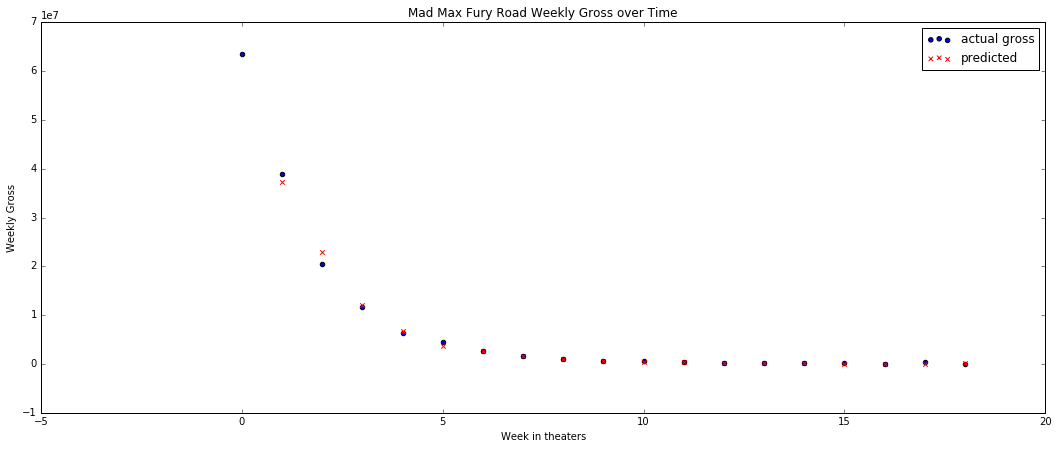

In [105]:
# plot actuals and predicted

x = range(len(weekly_timeseries))
y_true = weekly_timeseries
# plot actual grosses (blue spheres)
plt.scatter(x,y_true, label="actual gross")

# we can only predict for weeks where we have a number for
# the previous week. That is a feature. 
x_pred = x[1:]
y_pred = model.predict(X)

# plot model prediction (red x signs)
plt.scatter(x_pred,y_pred, color='red', marker="x", label="predicted")

# Labels
plt.title("Mad Max Fury Road Weekly Gross over Time")
plt.xlabel("Week in theaters")
plt.ylabel("Weekly Gross")
plt.legend();

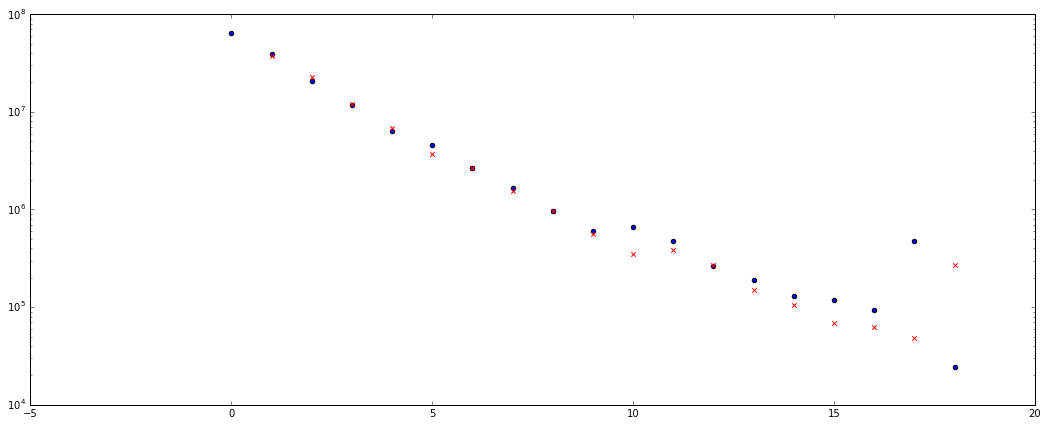

In [106]:
# plot on log scale

plt.scatter(x,y_true)
plt.scatter(x_pred,y_pred, color='red', marker="x")
plt.yscale('log')

We are still plotting it over time. The model doesn't know about time. For each point, it sees an input feature (previous week's gross) and a target value (this week's gross). Let's try and look at these points from a viewpoint closer to the model's. Let's plot the target versus our single feature.

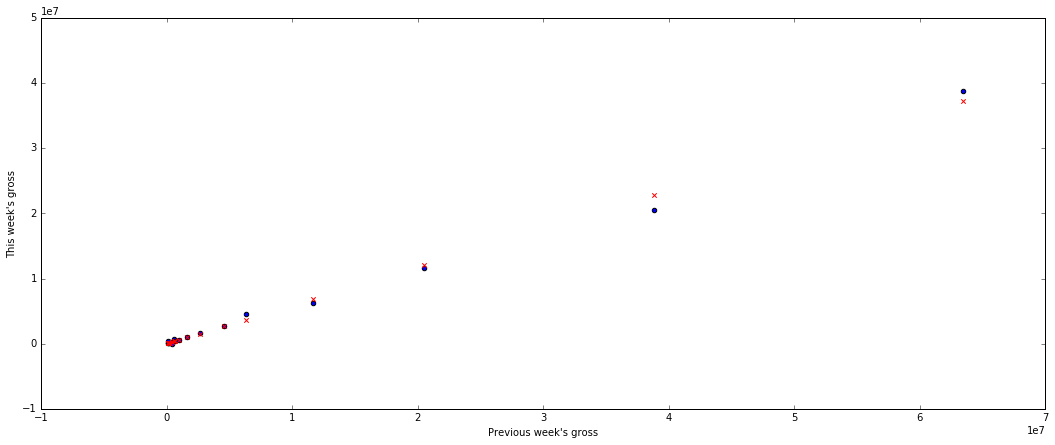

In [107]:
plt.scatter(previous_weeks_grosses[1:], weekly_timeseries[1:])
plt.scatter(previous_weeks_grosses[1:], y_pred, color='red', marker='x')
plt.xlabel("Previous week's gross")
plt.ylabel("This week's gross");

Looking at orders of magnitude (logarithms of the grosses) will make it clearer to see those clustered points.

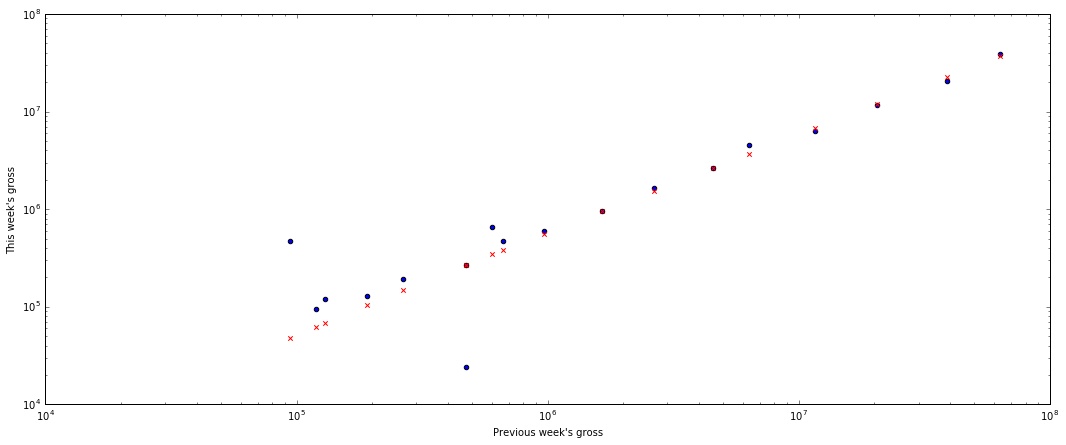

In [108]:
plt.scatter(previous_weeks_grosses[1:], weekly_timeseries[1:])
plt.scatter(previous_weeks_grosses[1:], y_pred, color='red', marker='x')
plt.xlabel("Previous week's gross")
plt.ylabel("This week's gross")
plt.xscale('log')
plt.yscale('log')

Looking at it this way, we can see it as just another regular regression problem.

So, already by looking at what the movie made last week, the model gathers a pretty good idea of what to expect this week. If we add more information about the past, like not only last week, but what it made the two previous weeks, we could get even better estimates. More lag doesn't necessarily mean 'better' models. Of course it will fit the training data better, but the extra complexity might be just overfitting to the data at hand. Just like any other regression model where we 

When we add a 2-lag feature (meaning grosses from two weeks ago & last week in our case), the model is called AR-2 (AR for **A**uto**R**egressive). When we use up to three, it is called AR-3 and so on. Let's do an AR-2.

In [109]:
grosses_two_weeks_prior = [None] * len(weekly_timeseries)
for week in range(2, len(weekly_timeseries)):
    grosses_two_weeks_prior[week] = weekly_timeseries[week-2]

grosses_two_weeks_prior

[None,
 None,
 63440279,
 38849255,
 20544731,
 11643562,
 6309002,
 4555993,
 2648047,
 1645168,
 966275,
 601794,
 663222,
 471641,
 266007,
 190614,
 129637,
 119106,
 94384]

In [110]:
timeseries_df["two_prev_weeks_gross"] = grosses_two_weeks_prior
timeseries_df

,weekly_gross,one_prev_weeks_gross,two_prev_weeks_gross
0,63440279,NaN,NaN
1,38849255,63440279.0,NaN
2,20544731,38849255.0,63440279.0
3,11643562,20544731.0,38849255.0
4,6309002,11643562.0,20544731.0
5,4555993,6309002.0,11643562.0
6,2648047,4555993.0,6309002.0
7,1645168,2648047.0,4555993.0
8,966275,1645168.0,2648047.0
9,601794,966275.0,1645168.0


In [111]:
AR2_model = LinearRegression()
X = timeseries_df.dropna()[["one_prev_weeks_gross", "two_prev_weeks_gross"]]
y = timeseries_df.dropna()[["weekly_gross"]]
AR2_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [112]:
AR2_model.coef_, AR2_model.intercept_

(array([[ 0.27113585,  0.15521272]]), array([ 184055.7504095]))

This new model is saying, take 15% of the gross from two weeks ago, add to that 27% of last week's gross, add $184K to it, plus the small luck factor -- that's what this week's gross will be.

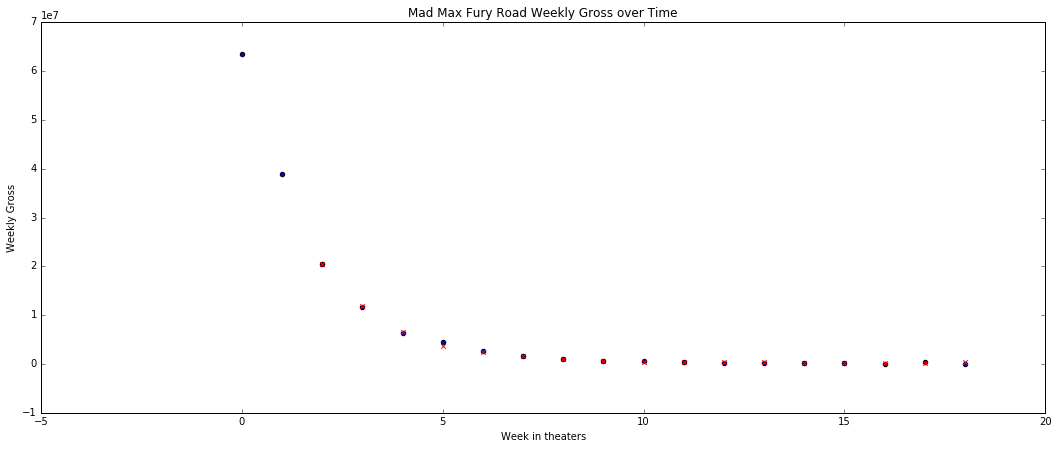

In [113]:
x = range(len(weekly_timeseries))
y_true = weekly_timeseries
# plot actual grosses (blue spheres)
plt.scatter(x,y_true)

# we can only predict for weeks where we have a number for
# the previous week AND two weeks ago. So our model can now
# start predicting only at the 3rd week for a movie.
x_pred = x[2:]
y_pred = AR2_model.predict(X)

# plot model prediction (red x signs)
plt.scatter(x_pred,y_pred, color='red', marker="x")

# Labels
plt.title("Mad Max Fury Road Weekly Gross over Time")
plt.xlabel("Week in theaters")
plt.ylabel("Weekly Gross");

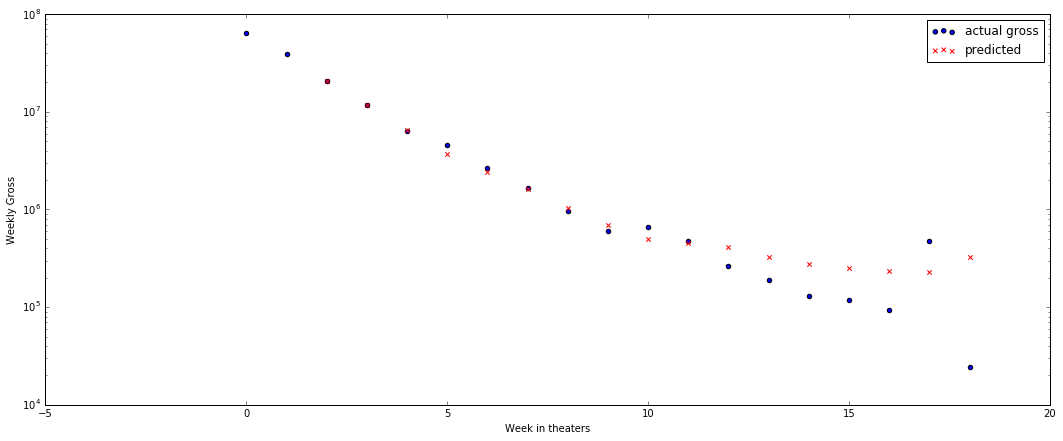

In [114]:
plt.scatter(x,y_true, label="actual gross")
plt.scatter(x_pred,y_pred, color='red', marker="x", label="predicted")
plt.yscale('log')
plt.xlabel("Week in theaters")
plt.ylabel("Weekly Gross")
plt.legend();

As you can see, this model is different. It is smoother. Our previous model was only looking at last week and that single jump towards the end was throwing it off for those last few points. Here, because the model is looking at a longer range of the past, it is starting to predict a general level for those last low gross amounts.

We have manually constructed our features based on past performance. Since this is common for time series, there are actually short-hand interfaces to build such AR models. In statsmodels, for example, you can just use the gross values over time as the input to an AR model and it will automatically do what we just did. Let's take a look.

In [115]:
import statsmodels.api as sm
weekly_timeseries

[63440279,
 38849255,
 20544731,
 11643562,
 6309002,
 4555993,
 2648047,
 1645168,
 966275,
 601794,
 663222,
 471641,
 266007,
 190614,
 129637,
 119106,
 94384,
 473315,
 24322]

In [116]:
# freq set as "W" means these numbers are weekly -- this is required 
# to make it possible to make predictions with datetime objects later,
# as is usually practical with time series models.
# The maxlag=1 means we are using a single lag feature, so this is an AR-1.
sm_AR1_model = sm.tsa.AR(weekly_timeseries, freq="W").fit(maxlag=1)
print(sm_AR1_model.params)

[ -7.62830132e+03   5.88061907e-01]


As you can see, these are the same coefficients! The intercept first, and then the coefficient for our only feature: Previous week's gross. Take 58% of last week, subtract $7600K, there's our estimate. You can see it if we plot it, too.

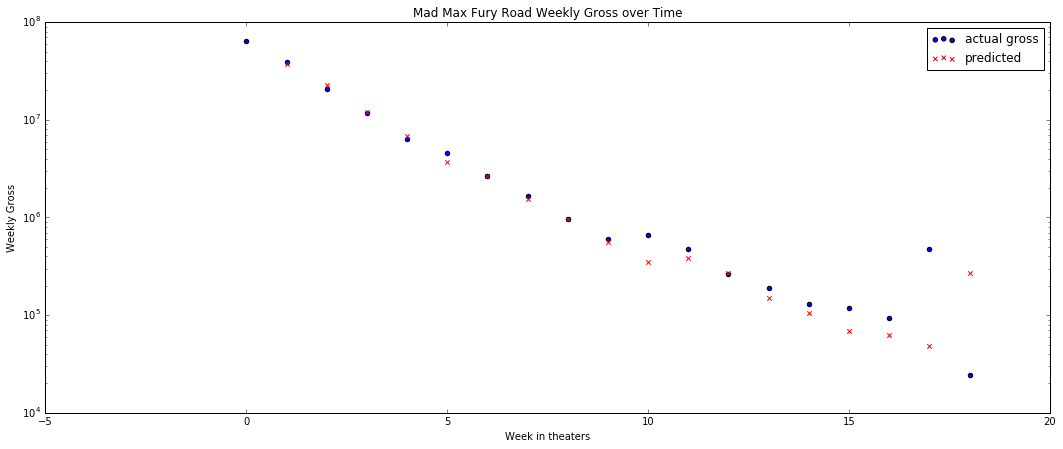

In [117]:
x = range(len(weekly_timeseries))
y_true = weekly_timeseries
# plot actual grosses (blue spheres)
plt.scatter(x,y_true, label='actual gross')

x_pred = x[1:]
y_pred = sm_AR1_model.predict()

# plot model prediction (red x signs)
plt.scatter(x_pred,y_pred, color='red', marker="x", label='predicted')

# Labels
plt.title("Mad Max Fury Road Weekly Gross over Time")
plt.xlabel("Week in theaters")
plt.ylabel("Weekly Gross")
plt.yscale('log')
plt.legend()

This makes it easy to fit any AR type model. AR2 or AR3 are simple changes of maxlag.

In [118]:
sm_AR2_model = sm.tsa.AR(weekly_timeseries, freq="W").fit(maxlag=2)
print(sm_AR2_model.params)

[  1.84055750e+05   2.71135854e-01   1.55212721e-01]


In [119]:
sm_AR3_model = sm.tsa.AR(weekly_timeseries, freq="W").fit(maxlag=3)
print(sm_AR3_model.params)

[  1.73898123e+05   2.99677232e-01   1.18869792e-01   1.29184801e-02]


### Preprocessing: Smoothing out the noise
Ok. Now let's see what happens if there is more noise. We were looking at weekly grosses. Basically, by summing up each daily gross, we are averaging out some of that daily noise. What if we looked at each day? Easy enough to get from boxofficemojo by going to the daily page for the same movie.

In [120]:
url = "http://www.boxofficemojo.com/movies/?page=daily&view=chart&id=furyroad.htm"

response = requests.get(url)
page = response.text
soup = BeautifulSoup(page)

# eac
daily_gross_table = soup.find('table', {"class":"chart-wide"})
daily_timeseries = extract_gross_points_from_table(daily_gross_table, gross_column=3)
daily_timeseries

[16611428,
 16145936,
 12670764,
 5329473,
 5031242,
 3933036,
 3708400,
 6691708,
 8926676,
 9020878,
 6648179,
 3045462,
 2318209,
 2208143,
 3880449,
 5820128,
 4477659,
 1648447,
 1985244,
 1457348,
 1275456,
 2338428,
 3241587,
 2251438,
 989046,
 1152490,
 951219,
 719354,
 1207792,
 1676550,
 1181625,
 542680,
 618347,
 562083,
 519925,
 738959,
 1098841,
 1195249,
 376030,
 461402,
 363386,
 322126,
 444374,
 737290,
 582772,
 242233,
 245481,
 178396,
 217511,
 390636,
 310952,
 314418,
 162234,
 183390,
 154047,
 129481,
 171052,
 251161,
 194935,
 88670,
 102857,
 87550,
 70040,
 105387,
 156620,
 122342,
 55054,
 62413,
 51802,
 48176,
 115109,
 168355,
 134728,
 60322,
 68163,
 57983,
 58562,
 78736,
 111558,
 112023,
 45781,
 42136,
 42698,
 38709,
 45729,
 68075,
 52561,
 25331,
 26090,
 24524,
 23697,
 34411,
 51370,
 36366,
 17819,
 17809,
 16806,
 16033,
 23724,
 33105,
 22542,
 10662,
 12620,
 14545,
 12439,
 30029,
 33792,
 22812,
 8265,
 8665,
 7651,
 7892,
 16314,

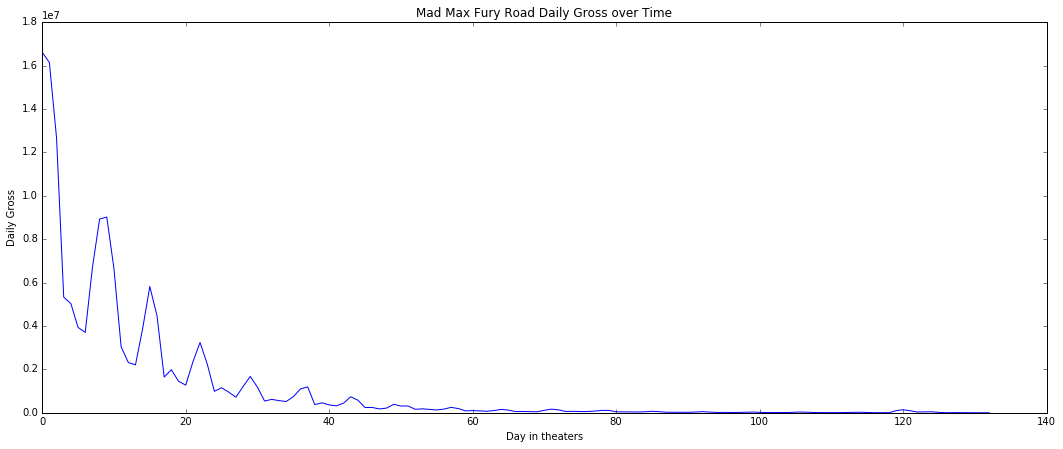

In [121]:
x = range(len(daily_timeseries))
y = daily_timeseries
plt.plot(x,y)
plt.title("Mad Max Fury Road Daily Gross over Time")
plt.xlabel("Day in theaters")
plt.ylabel("Daily Gross")

We can see that it fluctuates. This is a somewhat patterned fluctuation, we have a spike every weekend, since many more people watch movies on the weekend compared to weekdays. So, actually summing up or averaging the daily grosses for each week, and then using the weekly time series is a very good pre-processing to apply to this data.

There are of course tons of other time series where the noise is less patterned. Take the following time series of an instructor's weight, for example, taken every day (in kgs) for a long stretch. First of all, stop judging! :)

Here we can see the daily fluctuations that would make it tough if we just used something like AR-1 or AR-2. Our amazing human brains with great pattern-finding capabilities can immediately see the trend, but on the small scale, zoomed into a few points next to each other, the noise has some effect.

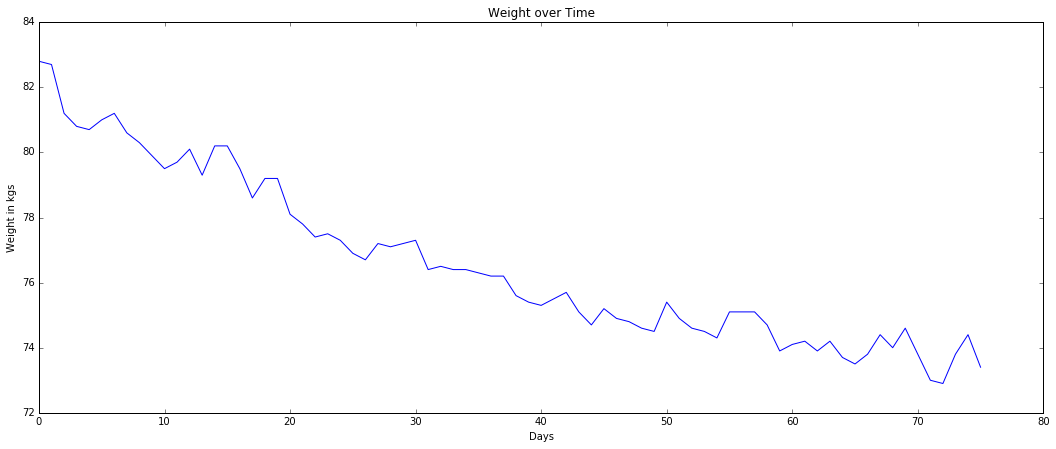

In [122]:
weight_timeseries = [82.8, 82.7, 81.2, 80.8, 80.7, 81, 81.2, 80.6, 80.3, 79.9, 79.5, 79.7, 80.1, 79.3, 80.2, 80.2, 79.5, 78.6, 79.2, 79.2, 78.1, 77.8, 77.4, 77.5, 77.3, 76.9, 76.7, 77.2, 77.1, 77.2, 77.3, 76.4, 76.5, 76.4, 76.4, 76.3, 76.2, 76.2, 75.6, 75.4, 75.3, 75.5, 75.7, 75.1, 74.7, 75.2, 74.9, 74.8, 74.6, 74.5, 75.4, 74.9, 74.6, 74.5, 74.3, 75.1, 75.1, 75.1, 74.7, 73.9, 74.1, 74.2, 73.9, 74.2, 73.7, 73.5, 73.8, 74.4, 74, 74.6, 73.8, 73, 72.9, 73.8, 74.4, 73.4]
x = range(len(weight_timeseries))
y = weight_timeseries
plt.plot(x,y)
plt.title("Weight over Time")
plt.xlabel("Days")
plt.ylabel("Weight in kgs")

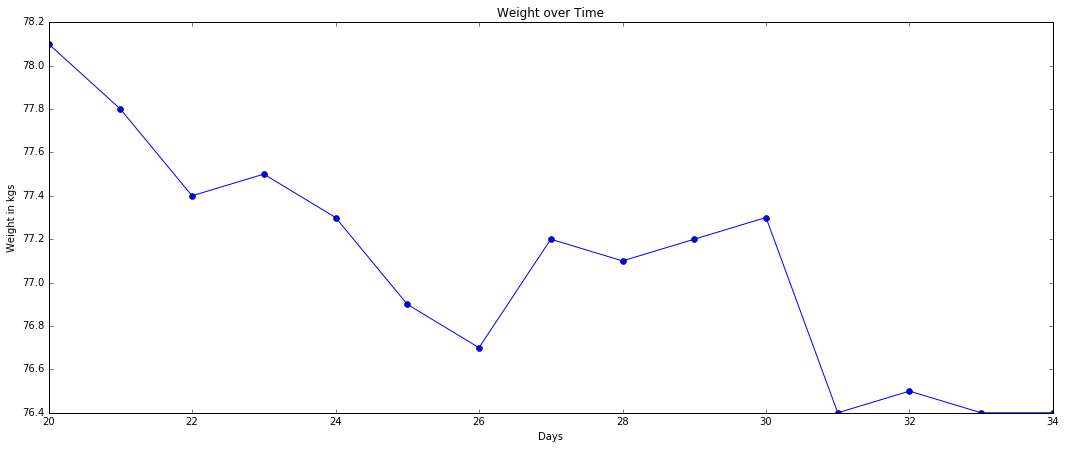

In [123]:
# Zoom in
plt.plot(x[20:35],y[20:35], 'o-')
plt.title("Weight over Time")
plt.xlabel("Days")
plt.ylabel("Weight in kgs")

Basically, that daily luck factor in our stochastic process model is causing fluctuations that makes it a bit harder for the model to fit that underlying process. If we can eliminate the noise a bit, we can fit better. In fact, this is exactly what we did in the beginning by looking at weekly timeseries instead of daily. By averaging (or summing -- same effect) over a bunch of points, we are letting the noise from different days cancel each other.

Now, in some cases, such as the weekly grosses, there are logical units, bins, to average/sum over. In movies, each week is one unit that makes sense in the system. Every week there are new movies released, new competitors, so it makes sense to treat each week separately. In the case of the weight, however, there is no discrete jump from one unit to the other as in the case of movies. So, if we wanted to get rid of the noise, instead of just dividing the time into bins, a better approach is to take a **moving average**. Basically, take a window of n points, take their average to represent that whole window, then slide the window by one point to the future (remove oldest point, add the next point) average again. Let's do that here with a 10-day moving average window and see how it helps.

In [124]:
MA_10 = [None] * len(weight_timeseries)
start, end = 5, len(MA_10)-5
for window in range(start, end):
    points_in_window = [weight_timeseries[i] for i in range(window-5, window+5)]
    MA_10[window] = sum(points_in_window)/10.
    
MA_10[:20]

[None,
 None,
 None,
 None,
 None,
 81.11999999999999,
 80.78999999999999,
 80.49,
 80.38000000000001,
 80.23,
 80.18,
 80.1,
 79.92999999999999,
 79.73,
 79.62000000000002,
 79.55000000000001,
 79.41000000000001,
 79.22,
 78.94999999999999,
 78.77]

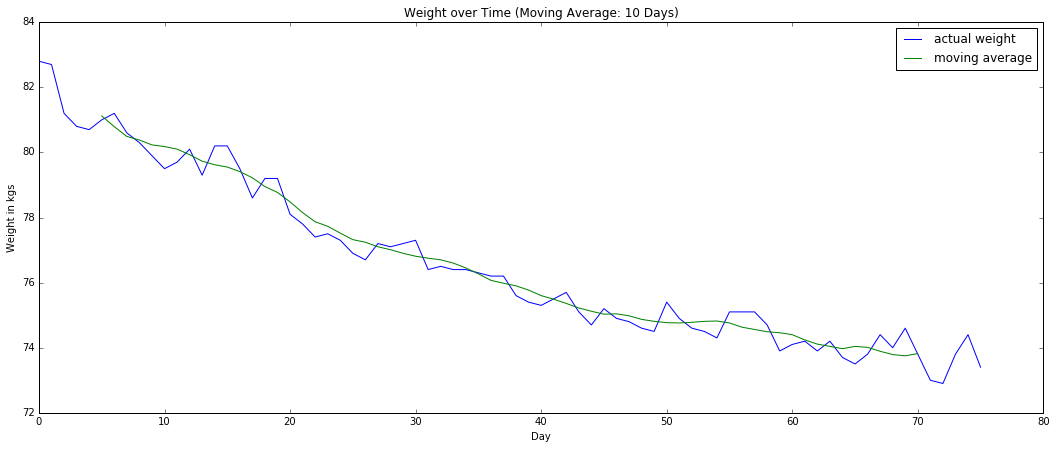

In [125]:
x = range(len(weight_timeseries))
y_real = weight_timeseries

start, end = 5, len(MA_10)-5
x_ma = range(start, end)
y_ma = MA_10[start:end]

plt.plot(x,y, label="actual weight")
plt.plot(x_ma, y_ma, color='green', label="moving average")
plt.title("Weight over Time (Moving Average: 10 Days)")
plt.xlabel("Day")
plt.ylabel("Weight in kgs")
plt.legend()

As you can see, the moving average gives us a much smoother, less noisy dataset, making it easier to define the underlying process. Of course, just like in the case of the AR models, we get fewer points (since we lose 5 at the start and 5 at the end) to use in a model.

**Remember**: When you are doing preprocessing like this, you are putting some of your prior information or assumptions about the system into your model. The window size you choose reflects your belief about what portion of the fluctuations are noise. If you choose a rolling window of 5 points, you are saying that the underlying value would not change much within a time window of 5 points. So, the ups and downs must be from noise. By inserting more information, you make it easier to model the changes. But of course **be mindful of your assumptions, and keep checking their validity wherever you can.**

Don't let this scare you, though. Making assumptions like this is normal, it isn't evil at all. Even by doing linear regression, we are making a lot of assumptions. Quite a few of those assumptions (such as a perfectly well behaving gaussian noise with the same standard deviation throughout) are usually wrong, but they are close enough that our models are still very useful.

### Implementation in pandas
Pandas actually provides a function to do the moving average.
`pd.stats.moments.rolling_mean`

In [126]:
weight_df = pd.DataFrame(weight_timeseries, columns=["Weight"])
weight_df["Weight_MA10"] = pd.stats.moments.rolling_mean(weight_df, window=10)
weight_df.head(20)

/Users/jb/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


,Weight,Weight_MA10
0,82.8,NaN
1,82.7,NaN
2,81.2,NaN
3,80.8,NaN
4,80.7,NaN
5,81.0,NaN
6,81.2,NaN
7,80.6,NaN
8,80.3,NaN
9,79.9,81.12


This actually assigns the mean of the *last 10 points* to the last time point of the window. If we instead want to center that value (like we did up there manually), we can do that as well, with the `center` keyword argument. This is important if the underlying trend is going up or down (your data is not *stationary*). Otherwise, for example in this case, since the weight is generally going down, our average of the last 10 weights will be higher than what we should assign the last point.

In [127]:
weight_df["Weight_MA10"] = pd.stats.moments.rolling_mean(weight_df, window=10, center=True)
weight_df.head(20)

/Users/jb/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  if __name__ == '__main__':


,Weight,Weight_MA10
0,82.8,NaN
1,82.7,NaN
2,81.2,NaN
3,80.8,NaN
4,80.7,NaN
5,81.0,81.12
6,81.2,80.79
7,80.6,80.49
8,80.3,80.38
9,79.9,80.23


Of course, we weighed every single point in the window equally. You can use other schemes, such as weighing each point less and less as we go back into the past. A common way to do that is an exponential moving average, where the weight of each previous point falls down exponentially. Again, by choosing the form of that exponential decay (like halflife, or span, or center of mass), we are putting in assumptions about the system, specifically in terms of how we believe noise works.

In pandas, you can do this with `pandas.stats.moments.ewma`, where ewma stands for exponentially weighted moving average. We are using `halflife = 5` to set the shape of the exponential decay. This means that by the time we are at the 5th previous point, the weight we are using is half of the weight of the current point. By the time we are at the 10th previous point, the weight is half of the weight we used at the 5th previous point (and of course one quarter of the weight we gave the current point).

In [128]:
ewma= pd.stats.moments.ewma(weight_df, halflife=5)
ewma.head(20)

/Users/jb/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=5,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


,Weight,Weight_MA10
0,82.800000,NaN
1,82.746540,NaN
2,82.158146,NaN
3,81.745105,NaN
4,81.474528,NaN
5,81.365754,81.120000
6,81.331206,80.943581
7,81.189957,80.771013
8,81.028341,80.652097
9,80.833590,80.542817


Unfortunately, `ewma` is again doing an averaging into the past and assigning this to the last point. If your time series has a trend in one direction, you get the same problem of over/under estimating the appropriate value. You can overcome this by doing both a forward `ewma` and a backward `ewma` and averaging those two values for all time points.

### Moving Average Smoothing vs Moving-Average models: Not the same
Now, what we covered above is a **moving average**, a way to smooth data, get rid of noise before using it to train a model (like an AR model). It can sometimes be a valid way to preprocess noisy timeseries data prior to (any type of) modeling. Smoothing out the noise can especially help to avoid overfitting and training models that generalize well to new data.

There is also a different way of modeling time series data, which is called a **Moving Average Model**. Like auto-regressive (AR) models, moving-average models try to forecast future values by fitting a model to the observed data over time. The **Moving Average Model** is **not** the same thing as a **moving average**. While there are some remote similarities, these two concepts are different.

The moving average model (**MA**) is actually quite similar to the autoregressive model (AR) in the sense that it is using a few previous points as input to forecast the future point. One big difference is that MA is using the noise contributions from the past as input features, rather than the final observed values (which includes that noise contribution).

MA assumes that it is modeling **stationary** data, which means that it assumes the mean of the time series is not changing and will never change within a large enough sliding window. While locally, during some short time period the mean of a small window might change, generally the time series will stay around the same mean. So, basically, the MA model is a model about modeling "noise" around a mean. It is still trying to predict the value for the next point, but the inputs differ from AR.  Instead of using the absolute values for the past few points, it is using the noise from the previous points.Since the noise for each point cannot be observed directly and separately, fitting an MA model is more complicated and needs to involve non-linear optimization methods.

**ARMA** models combine both AR features and MA features in a single model. **ARIMA** models add another trick: Differencing (converting each point from its absolute value into a difference from the previous value). We will touch upon MA, ARMA, ARIMA models later in the bootcamp again. Feel free to read on them if you like, but for a lot of time series cases, the straightforward auto-regressive modeling gives you a strong modeling tool, that works exactly like any other regression problem.